In [2]:
!pip install wordcloud

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from collections import Counter

**Load Data**

Three csv dataset: ratings, tags, movies

In [5]:
# Load datasets
ratings_df = pd.read_csv('ratings_small.csv')
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)
keywords_df = pd.read_csv('keywords.csv')
credits_df = pd.read_csv('credits.csv')

# Drop unnecessary columns from movies_metadata
movies_df = movies_df[['id', 'title', 'genres', 'original_language', 'release_date']].rename(columns={'id': 'movieId'})

# Drop the timestamp column from ratings_df
ratings_df.drop(columns=['timestamp'], inplace=True)

# Convert movieId to numeric
movies_df['movieId'] = pd.to_numeric(movies_df['movieId'], errors='coerce')
keywords_df['movieId'] = pd.to_numeric(keywords_df['id'], errors='coerce')
credits_df['movieId'] = pd.to_numeric(credits_df['id'], errors='coerce')

# Drop original 'id' columns
keywords_df.drop(columns=['id'], inplace=True)
credits_df.drop(columns=['id'], inplace=True)

# Drop NaN movieIds
movies_df.dropna(subset=['movieId'], inplace=True)
credits_df.dropna(subset=['movieId'], inplace=True)

# Convert movieId to int
movies_df['movieId'] = movies_df['movieId'].astype(int)
credits_df['movieId'] = credits_df['movieId'].astype(int)
keywords_df['movieId'] = keywords_df['movieId'].astype(int)

In [6]:
# Function to safely extract JSON data
def extract_json_column(data, column):
    """Extracts 'name' values from JSON-like columns safely."""
    def parse_json(text):
        try:
            if isinstance(text, str):
                return ', '.join([i['name'] for i in ast.literal_eval(text)])
            else:
                return ''
        except (ValueError, SyntaxError):
            return ''

    data[column] = data[column].fillna('[]').apply(parse_json)
    return data

# Extract the director's name
def get_director(crew_str):
    """Extracts the director from the crew column (stringified JSON)."""
    try:
        crew_list = ast.literal_eval(crew_str) if isinstance(crew_str, str) else []
        for person in crew_list:
            if person.get('job') == 'Director':
                return person.get('name', '')
    except (ValueError, SyntaxError):
        pass
    return ''

# Extract the top 3 actors
def get_top_3_cast(cast_str):
    """Extracts the top 3 actors from the cast column (stringified JSON)."""
    try:
        cast_list = ast.literal_eval(cast_str) if isinstance(cast_str, str) else []
        return [actor['name'] for actor in cast_list[:3]]
    except (ValueError, SyntaxError):
        return []
        
# Apply extraction to keywords and credits
keywords_df = extract_json_column(keywords_df, 'keywords')
credits_df['director'] = credits_df['crew'].apply(get_director)
credits_df['cast'] = credits_df['cast'].apply(get_top_3_cast)

# Extract genres from JSON format
def extract_genres(genre_str):
    """Extracts genre names from stringified JSON format."""
    try:
        genre_data = ast.literal_eval(genre_str) if isinstance(genre_str, str) else []
        return ', '.join([genre['name'] for genre in genre_data]) if genre_data else 'Other'
    except (ValueError, SyntaxError, TypeError):
        return 'Other'

movies_df['genres'] = movies_df['genres'].fillna('[]').apply(extract_genres)
movies_df['genres'] = movies_df['genres'].replace('', 'Other')

# Merge credits and keywords into movies_df
movies_df = movies_df.merge(credits_df[['movieId', 'cast', 'director']], on='movieId', how='left')
movies_df = movies_df.merge(keywords_df[['movieId', 'keywords']], on='movieId', how='left')

# Fill missing values with empty lists or empty strings
movies_df['keywords'] = movies_df['keywords'].fillna('').apply(lambda x: x if isinstance(x, str) else '')

print(movies_df.head())
print(ratings_df.head())

   movieId                        title                      genres  \
0      862                    Toy Story   Animation, Comedy, Family   
1     8844                      Jumanji  Adventure, Fantasy, Family   
2    15602             Grumpier Old Men             Romance, Comedy   
3    31357            Waiting to Exhale      Comedy, Drama, Romance   
4    11862  Father of the Bride Part II                      Comedy   

  original_language release_date  \
0                en   1995-10-30   
1                en   1995-12-15   
2                en   1995-12-22   
3                en   1995-12-22   
4                en   1995-02-10   

                                                cast         director  \
0                [Tom Hanks, Tim Allen, Don Rickles]    John Lasseter   
1     [Robin Williams, Jonathan Hyde, Kirsten Dunst]     Joe Johnston   
2         [Walter Matthau, Jack Lemmon, Ann-Margret]    Howard Deutch   
3  [Whitney Houston, Angela Bassett, Loretta Devine]  Forest Whi

In [7]:
# Merge credits and keywords into movies_df (avoid duplicate column names)
movies_df = movies_df.merge(
    credits_df[['movieId', 'cast', 'director']], on='movieId', how='left', suffixes=('', '_credits')
)
movies_df = movies_df.merge(
    keywords_df[['movieId', 'keywords']], on='movieId', how='left', suffixes=('', '_keywords')
)

# Drop any accidental duplicate columns (if still present)
movies_df = movies_df.drop(columns=['cast_credits', 'director_credits', 'keywords_keywords'], errors='ignore')

# Fill missing values appropriately
movies_df['cast'] = movies_df['cast'].apply(lambda x: x if isinstance(x, list) else [])
movies_df['director'] = movies_df['director'].fillna('')
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: x if isinstance(x, str) else '')

print(movies_df.head())
print(ratings_df.head())

   movieId                        title                      genres  \
0      862                    Toy Story   Animation, Comedy, Family   
1     8844                      Jumanji  Adventure, Fantasy, Family   
2    15602             Grumpier Old Men             Romance, Comedy   
3    31357            Waiting to Exhale      Comedy, Drama, Romance   
4    11862  Father of the Bride Part II                      Comedy   

  original_language release_date  \
0                en   1995-10-30   
1                en   1995-12-15   
2                en   1995-12-22   
3                en   1995-12-22   
4                en   1995-02-10   

                                                cast         director  \
0                [Tom Hanks, Tim Allen, Don Rickles]    John Lasseter   
1     [Robin Williams, Jonathan Hyde, Kirsten Dunst]     Joe Johnston   
2         [Walter Matthau, Jack Lemmon, Ann-Margret]    Howard Deutch   
3  [Whitney Houston, Angela Bassett, Loretta Devine]  Forest Whi

Filter Movies Released After 1980

In [9]:
# Convert release_date to datetime, errors='coerce' converts invalid dates to NaT
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['release_year'] = movies_df['release_date'].dt.year

# Movies after 1980
movies_df = movies_df[movies_df['release_year'] > 1980]
movies_df.dropna(subset=['release_year'], inplace=True)
movies_df.drop(columns=['release_date'], inplace=True)

# Ensure movieId consistency in ratings_df
ratings_df['movieId'] = pd.to_numeric(ratings_df['movieId'], errors='coerce')
ratings_df.dropna(subset=['movieId'], inplace=True)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)


**EDA and Visualization**

Dataset info and Missing Value

In [11]:
# Check data types
print("\nMovies dataset info:")
print(movies_df.info())

print("\nRatings dataset info:")
print(ratings_df.info())

# Check dataset shapes
print("Movies dataset shape:", movies_df.shape)
print("Ratings dataset shape:", ratings_df.shape)

# Check for missing values
print("\nMissing values in movies dataset:")
print(movies_df.isnull().sum())

print("\nMissing values in ratings dataset:")
print(ratings_df.isnull().sum())



Movies dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 36365 entries, 0 to 49492
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            36365 non-null  int32  
 1   title              36365 non-null  object 
 2   genres             36365 non-null  object 
 3   original_language  36359 non-null  object 
 4   cast               36365 non-null  object 
 5   director           36365 non-null  object 
 6   keywords           36365 non-null  object 
 7   release_year       36365 non-null  float64
dtypes: float64(1), int32(1), object(6)
memory usage: 2.4+ MB
None

Ratings dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int32  
 2   rating   100004 non-null  float64


In [12]:
# Drop rows with missing values
movies_df.dropna(subset=['original_language', 'keywords', 'cast'], inplace=True)
movies_df.reset_index(drop=True, inplace=True)

# Print new shape after dropping missing values
print("New Movies dataset shape:", movies_df.shape)

New Movies dataset shape: (36359, 8)


Data distribution

In [14]:
# Count unique movies and users
print(f"Total Unique Movies: {movies_df['movieId'].nunique()}")
print(f"Total Unique Users: {ratings_df['userId'].nunique()}")

Total Unique Movies: 33226
Total Unique Users: 671


Ratings Distribution

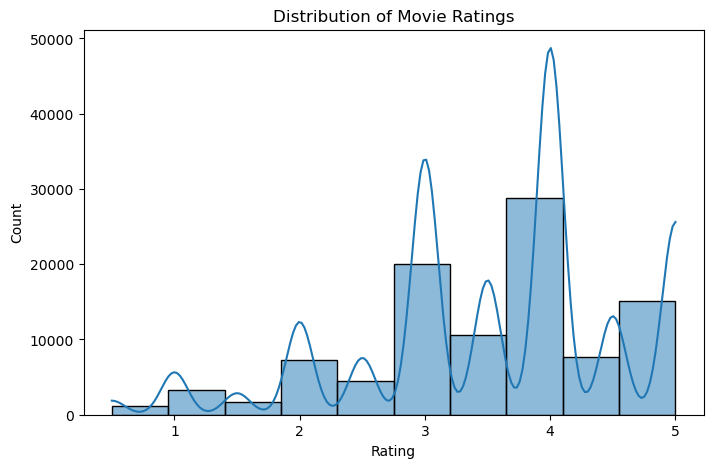

In [16]:
# Plot rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Movie Ratings")
plt.show()

C:\Users\wongj\AppData\Local\Temp\ipykernel_1868\121168848.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_counts_df, x='Count', y='Genre', palette='viridis')


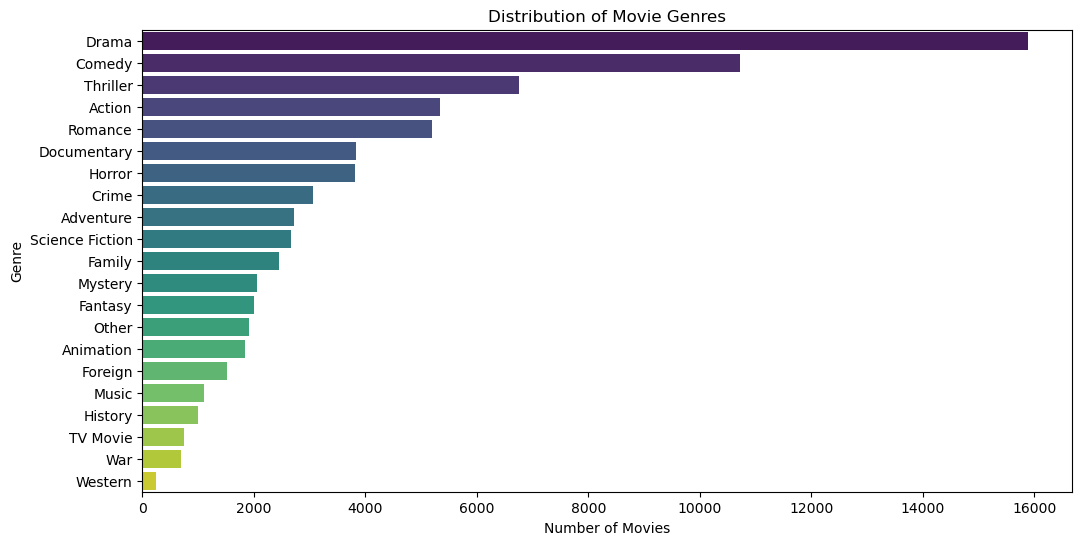

In [17]:
# Count genres
all_genres = ', '.join(movies_df['genres']).split(', ')
genre_counts = Counter(all_genres)

# Convert to DataFrame for visualization
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_counts_df, x='Count', y='Genre', palette='viridis')
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Distribution of Movie Genres")
plt.show()

C:\Users\wongj\AppData\Local\Temp\ipykernel_1868\2880426142.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_rated, x='num_ratings', y='title', palette='viridis')


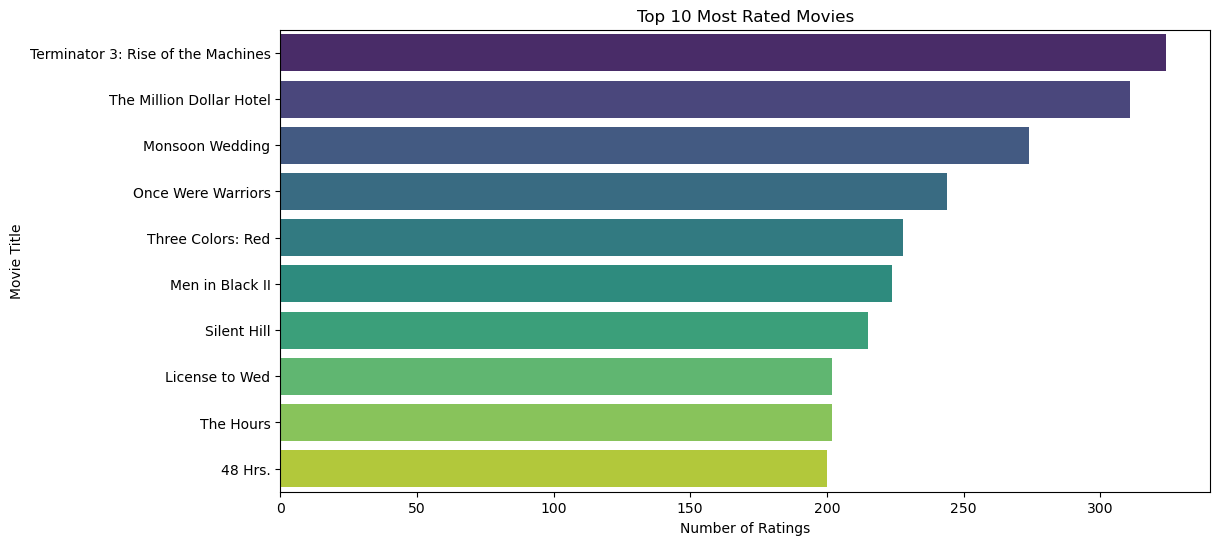

In [18]:
# Select top 10 most rated movies
movie_ratings_count = ratings_df.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count.columns = ['movieId', 'num_ratings']
movies_with_ratings = movies_df.merge(movie_ratings_count, on='movieId', how='left')
most_rated_movies = movies_with_ratings.sort_values(by='num_ratings', ascending=False)
top_10_rated = most_rated_movies[['title', 'num_ratings']].head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_rated, x='num_ratings', y='title', palette='viridis')
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Rated Movies")
plt.show()

C:\Users\wongj\AppData\Local\Temp\ipykernel_1868\2927531060.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_highest_rated, x='avg_rating', y='title', palette='coolwarm')


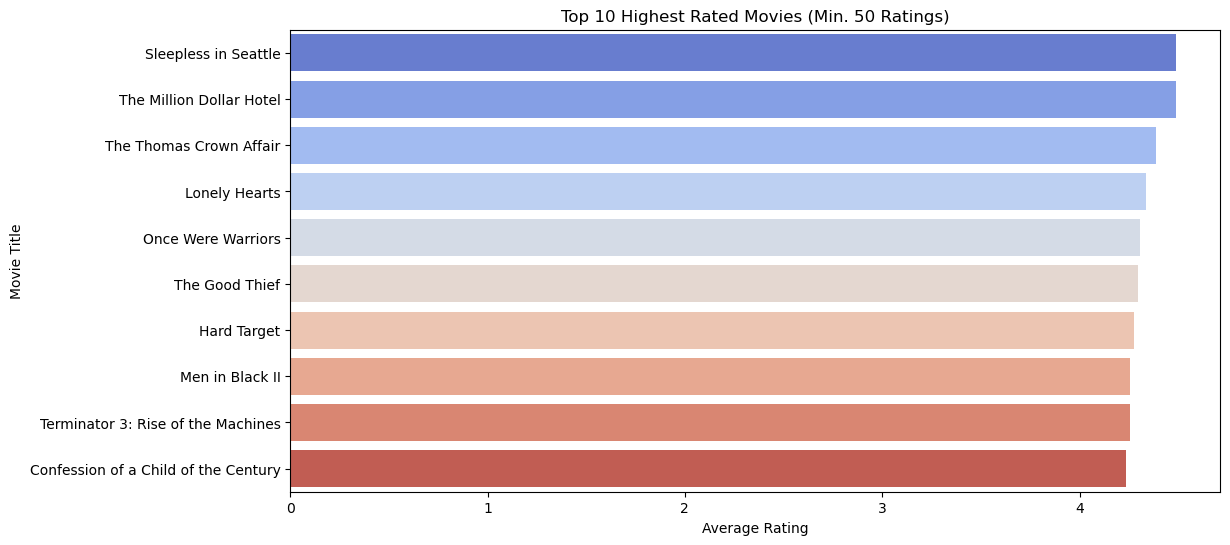

In [19]:
# Compute average rating per movie
average_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'avg_rating']
average_ratings = average_ratings.merge(movie_ratings_count, on='movieId', how='left')
popular_high_rated = average_ratings[average_ratings['num_ratings'] >= 50]
top_rated_movies = popular_high_rated.sort_values(by='avg_rating', ascending=False)
top_rated_movies = top_rated_movies.merge(movies_df[['movieId', 'title']], on='movieId')
top_10_highest_rated = top_rated_movies[['title', 'avg_rating', 'num_ratings']].head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_highest_rated, x='avg_rating', y='title', palette='coolwarm')
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Highest Rated Movies (Min. 50 Ratings)")
plt.show()

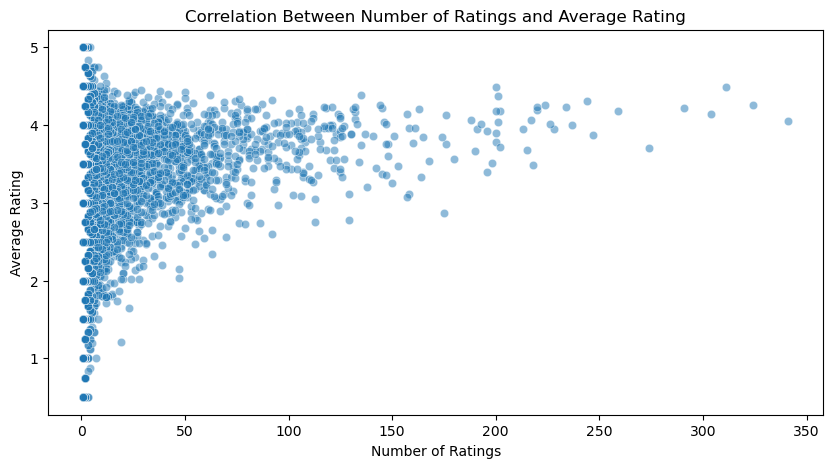

In [20]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=average_ratings, x='num_ratings', y='avg_rating', alpha=0.5)
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Correlation Between Number of Ratings and Average Rating")
plt.show()


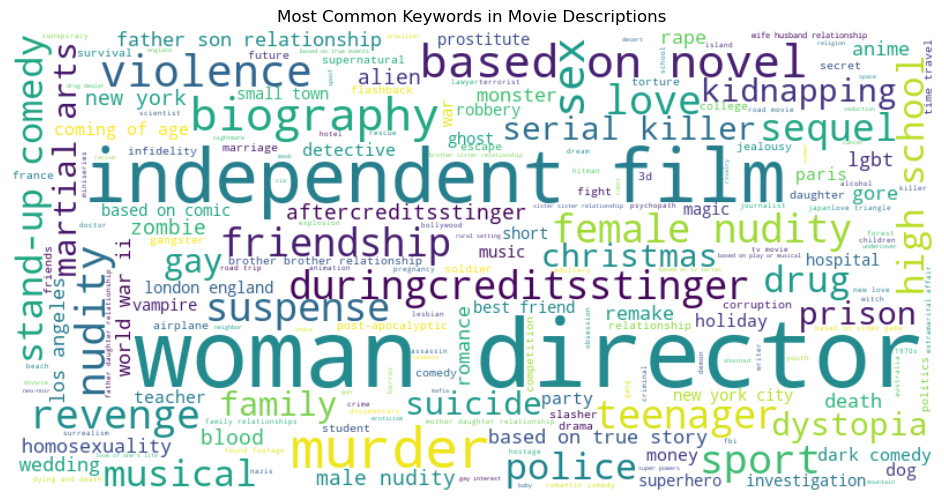

C:\Users\wongj\AppData\Local\Temp\ipykernel_1868\2949078174.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_keywords_df, x='Count', y='Keyword', palette='plasma')


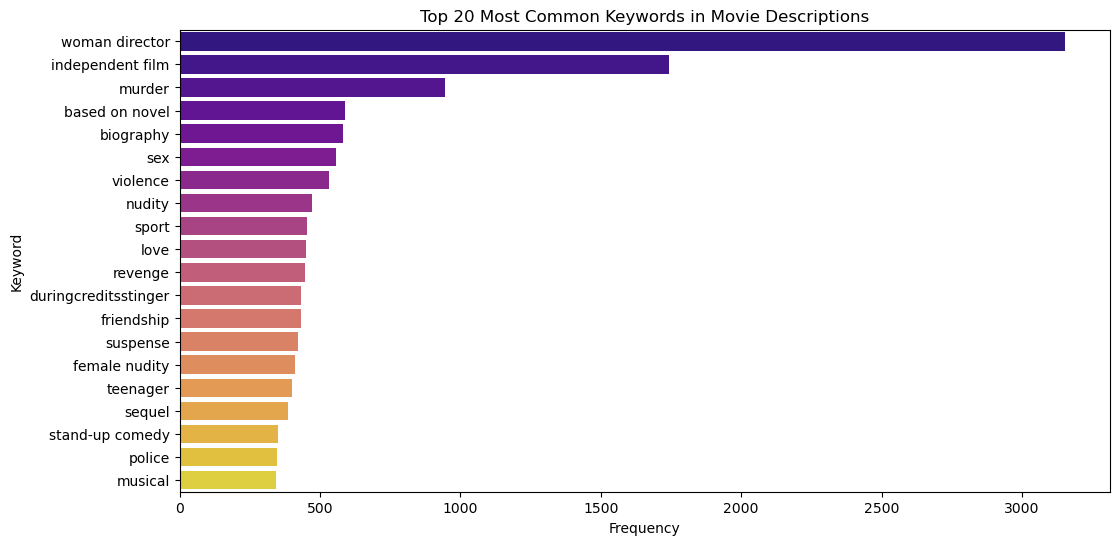

In [21]:
from collections import Counter
from wordcloud import WordCloud

# Remove NaN values and empty strings
movies_df['keywords'] = movies_df['keywords'].fillna('')  # Fill NaN with empty string
movies_df['keywords'] = movies_df['keywords'].str.strip()  # Remove extra spaces
movies_df = movies_df[movies_df['keywords'] != '']  # Drop empty strings

all_keywords = ', '.join(movies_df['keywords']).split(', ')
all_keywords = [kw.strip() for kw in all_keywords if kw.strip()]
keyword_counts = Counter(all_keywords)

# WordCloud visualization
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(keyword_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Keywords in Movie Descriptions")
plt.show()

# Bar plot of top 20 keywords
top_keywords_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count']).sort_values(by='Count', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_keywords_df, x='Count', y='Keyword', palette='plasma')
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 20 Most Common Keywords in Movie Descriptions")
plt.show()


**Data Cleaning**

Remove Duplicates

In [23]:
# Identify list-type columns
list_columns = ['genres', 'keywords', 'cast', 'director']

# Drop duplicate rows, excluding list-type columns
duplicate_movies = movies_df.drop(columns=list_columns, errors='ignore').duplicated()

print(f"Number of duplicate rows in movies dataset: {duplicate_movies.sum()}")

# Remove duplicate rows based on hashable columns
movies_df = movies_df.loc[~duplicate_movies]
print(f"Dataset after removing duplicates: {movies_df.shape}")


Number of duplicate rows in movies dataset: 1641
Dataset after removing duplicates: (21818, 8)


In [24]:
# Check for duplicates in ratings dataset
duplicate_ratings = ratings_df[ratings_df.duplicated()]

print(f"Number of duplicate rows in ratings dataset: {duplicate_ratings.shape[0]}")

# Remove duplicate ratings
ratings_df = ratings_df.drop_duplicates()

print(f"Dataset after removing duplicates: {ratings_df.shape}")


Number of duplicate rows in ratings dataset: 0
Dataset after removing duplicates: (100004, 3)


Text Cleaning

In [26]:
import re

# Function to clean text (remove special characters, lowercase, strip spaces)
def clean_text(value):
    if isinstance(value, str):
        value = value.lower()
        value = re.sub(r'[^a-zA-Z0-9\s]', '', value).strip()
    return value

# Clean movie titles and director names
movies_df['title'] = movies_df['title'].apply(clean_text)
movies_df['director'] = movies_df['director'].apply(clean_text)


In [27]:
# Clean the text (remove spaces & lowercase)
def clean_data(value):
    """Cleans data by removing spaces and converting to lowercase."""
    if isinstance(value, list):
        return [str.lower(i.replace(" ", "")) for i in value]
    elif isinstance(value, str):
        return str.lower(value.replace(" ", ""))
    return value

movies_df['cast'] = movies_df['cast'].apply(clean_data)
movies_df['genres'] = movies_df['genres'].apply(clean_data)
movies_df['keywords'] = movies_df['keywords'].apply(clean_data)
movies_df['director'] = movies_df['director'].apply(clean_data)


Convert Data Types

In [29]:
movies_df.info()
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21818 entries, 0 to 36356
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            21818 non-null  int32  
 1   title              21818 non-null  object 
 2   genres             21818 non-null  object 
 3   original_language  21818 non-null  object 
 4   cast               21818 non-null  object 
 5   director           21818 non-null  object 
 6   keywords           21818 non-null  object 
 7   release_year       21818 non-null  float64
dtypes: float64(1), int32(1), object(6)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int32  
 2   rating   100004 non-null  float64
dtypes: float64(1), int32(1), int64(1)
memory usag

In [30]:
# Convert release_year to int (removes decimal)
movies_df['release_year'] = movies_df['release_year'].astype(int)

print(movies_df.dtypes)
print(ratings_df.dtypes)


movieId               int32
title                object
genres               object
original_language    object
cast                 object
director             object
keywords             object
release_year          int32
dtype: object
userId       int64
movieId      int32
rating     float64
dtype: object


Make sure json format is stored as list

In [32]:
import json

def parse_genres(genre_str):
    if isinstance(genre_str, str):  # Ensure it's a string
        try:
            return json.loads(genre_str.replace("'", "\""))  # Convert to valid JSON
        except json.JSONDecodeError:  # If not JSON format, split by common delimiters
            return genre_str.split(", ")  # Adjust delimiter if necessary
    return genre_str  # Return original if already correct

movies_df['genres'] = movies_df['genres'].apply(parse_genres)

print("✅ Genres column successfully parsed!")

✅ Genres column successfully parsed!


In [33]:
import json

def parse_keywords(keyword_str):
    if isinstance(keyword_str, str):  # Ensure it's a string
        try:
            return [kw['name'] for kw in json.loads(keyword_str.replace("'", "\""))]  # Convert JSON
        except json.JSONDecodeError:  # If not JSON, assume comma-separated text
            return keyword_str.split(", ")  # Adjust delimiter if necessary
    return keyword_str  # Return original if already correct

movies_df['keywords'] = movies_df['keywords'].apply(parse_keywords)

print("✅ Keywords column successfully parsed!")


✅ Keywords column successfully parsed!


In [34]:
import json

def parse_cast(cast_str):
    if isinstance(cast_str, str):  # Ensure it's a string
        try:
            return [actor['name'] for actor in json.loads(cast_str.replace("'", "\""))]  # Convert JSON
        except json.JSONDecodeError:  # If not JSON, assume comma-separated text
            return cast_str.split(", ")  # Adjust delimiter if necessary
    return cast_str  # Return original if already correct

movies_df['cast'] = movies_df['cast'].apply(parse_cast)

print("✅ Cast column successfully parsed!")


✅ Cast column successfully parsed!


Last Checking

In [36]:
# Capitalize movie titles properly
movies_df['title'] = movies_df['title'].str.title()

# Convert stringified lists to actual lists (if stored as strings)
import ast
movies_df['genres'] = movies_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
movies_df['cast'] = movies_df['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def ensure_list(value):
    return value if isinstance(value, list) else []

movies_df['genres'] = movies_df['genres'].apply(ensure_list)
movies_df['keywords'] = movies_df['keywords'].apply(ensure_list)
movies_df['cast'] = movies_df['cast'].apply(ensure_list)

# Remove duplicates
movies_df.drop_duplicates(subset='movieId', keep='first', inplace=True)

print("Movies dataset cleaned and ready!")


Movies dataset cleaned and ready!


In [37]:
# Remove duplicate user-movie ratings, keeping the latest rating
ratings_df = ratings_df.sort_values(by=['userId', 'movieId', 'rating'], ascending=False)
ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId'], keep='first')

print("Ratings dataset cleaned and ready!")


Ratings dataset cleaned and ready!


In [38]:
import os
local_dir = "./CleanedData"
os.makedirs(local_dir, exist_ok=True)

# Save the cleaned CSV files
movies_df.to_csv(f"{local_dir}/movies_cleaned.csv", index=False)
ratings_df.to_csv(f"{local_dir}/ratings_cleaned.csv", index=False)

print("✅ Preprocessed datasets saved as CSV!")

✅ Preprocessed datasets saved as CSV!
